In [1]:
# %%
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import os
from scipy.io import loadmat
from torch.distributions import MultivariateNormal, Poisson
from cutbayesflow import CutBayesFlow, train_cut_bayes_flow
from cutbayesflow.utils import get_marginal_samples

# Get directory of current script
base_dir = os.getcwd()

# ─────────────────────────────────────────────────────────────
# 1) Load and Prepare Data
# ─────────────────────────────────────────────────────────────
torch.manual_seed(1010)
np.random.seed(627)

# Load second module data (Y21, Y22)
Y21_np = np.array([16, 215, 362, 97, 76, 62, 710, 56, 133, 28, 62, 413, 194]).reshape(1, -1)
Y22_np = np.array([26983, 250930, 829348, 157775, 150467, 352445, 553066, 26751, 75815, 150302, 354993, 3683043, 507218]).reshape(1, -1)

Y21 = torch.tensor(Y21_np, dtype=torch.float32)
Y22 = torch.tensor(Y22_np, dtype=torch.float32) / 1000  # Scale for numerical stability

# Load first module samples (theta1_samples)
theta1_path = os.path.join(base_dir, "stage1", "theta1_samples.mat")
data = loadmat(theta1_path)
theta1_samples = torch.tensor(data['theta1'], dtype=torch.float32)
n_samples, latent_dim = theta1_samples.shape  # (1000, 13)

# Broadcast Y21, Y22 to match theta1_samples
Y21 = Y21.repeat(n_samples, 1)  # shape: [1000, 13]
Y22 = Y22.repeat(n_samples, 1)

# Bundle second module data for likelihood
data_D2 = {
    "Y21": Y21,
    "Y22": Y22
}

# ─────────────────────────────────────────────────────────────
# 2) Define Prior and Likelihood Functions
# ─────────────────────────────────────────────────────────────
def prior_log_prob_fn(theta2):
    """
    Prior: Multivariate Normal N(0, 1000*I)
    """
    prior_std = torch.sqrt(torch.tensor(1000.0))
    prior = MultivariateNormal(loc=torch.zeros(2), covariance_matrix=torch.eye(2) * prior_std**2)
    return prior.log_prob(theta2)

def likelihood_log_prob_fn(theta2, theta1, data):
    """
    log p(Y21 | theta2, theta1) where
    Y21 ~ Poisson(exp(beta + gamma * theta1))
    """
    Y21, Y22 = data["Y21"], data["Y22"]

    beta = theta2[:, 0:1]   # shape: [N, 1]
    gamma = theta2[:, 1:2]  # shape: [N, 1]
    linear_predictor = beta + gamma * theta1  # shape: [N, 13]
    poisson_lambda = torch.exp(linear_predictor)  # shape: [N, 13]

    log_likelihood = Y21 * linear_predictor - Y22 * poisson_lambda - torch.lgamma(Y21 + 1)
    return log_likelihood.sum(dim=1)  # shape: [N]

# ─────────────────────────────────────────────────────────────
# 3) Initialize CutBayesFlow Model
# ─────────────────────────────────────────────────────────────
model = CutBayesFlow(
    prior_log_prob_fn=prior_log_prob_fn,
    likelihood_log_prob_fn=likelihood_log_prob_fn,
    eta_dim=latent_dim,
    theta_dim=2,  # beta, gamma
    num_layers=2,
    hidden_features=64,
    num_bins=25,
    tail_bound=35.0
)

# ─────────────────────────────────────────────────────────────
# 4) Train the Model
# ─────────────────────────────────────────────────────────────
print("Training CutBayesFlow on HPV real data...")
start_time = time.time()

loss_history = train_cut_bayes_flow(
    model=model,
    eta_samples=theta1_samples,
    data_D2=data_D2,  # Pass second module data cleanly
    epochs=5000,
    lr=0.005,
    patience=500,
    seed=402,
    log_interval=200  # Print every 200 steps
)
end_time = time.time()

print(f"Training completed in {end_time - start_time:.2f} seconds")


Training CutBayesFlow on HPV real data...
Using batch_size=1000 (full-batch: True)
Step     0 | Loss: 236431.921875 | LR: 5.00e-03
Step   200 | Loss: 12985.001953 | LR: 5.00e-03
Step   400 | Loss: 13063.159180 | LR: 5.00e-03
Step   600 | Loss: 13081.114258 | LR: 5.00e-03
Step   800 | Loss: 13031.750000 | LR: 5.00e-03
Step  1000 | Loss: 13052.463867 | LR: 5.00e-03
Step  1200 | Loss: 13043.125977 | LR: 5.00e-03
Epoch 01213: reducing learning rate of group 0 to 2.5000e-03.
Step  1400 | Loss: 13094.385742 | LR: 2.50e-03
Step  1600 | Loss: 13026.634766 | LR: 2.50e-03
Epoch 01801: reducing learning rate of group 0 to 1.2500e-03.
Step  1800 | Loss: 12983.719727 | LR: 1.25e-03
Step  2000 | Loss: 13094.046875 | LR: 1.25e-03
Step  2200 | Loss: 13016.699219 | LR: 1.25e-03
Epoch 02302: reducing learning rate of group 0 to 6.2500e-04.
Step  2400 | Loss: 13041.821289 | LR: 6.25e-04
Step  2600 | Loss: 13045.850586 | LR: 6.25e-04
Step  2800 | Loss: 13005.938477 | LR: 6.25e-04
Epoch 02803: reducing lea

Text(0, 0.5, 'Loss')

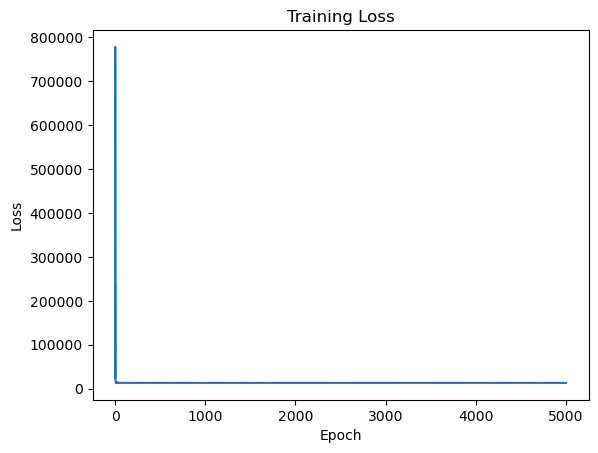

In [2]:
# Plot Loss
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

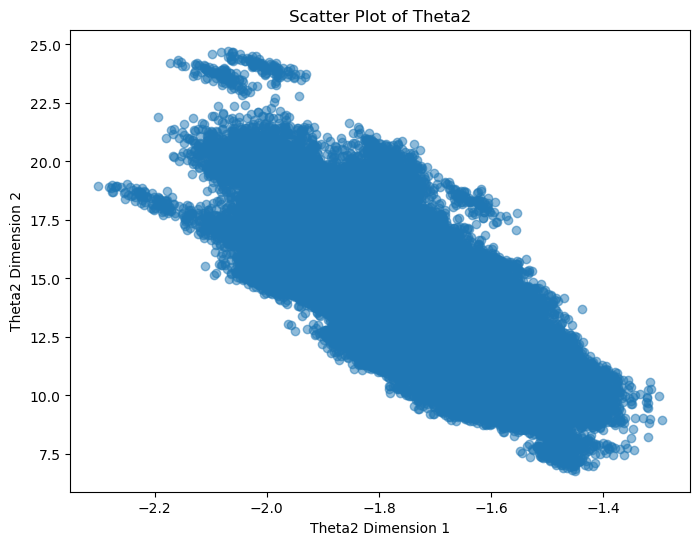

In [3]:
# ─────────────────────────────────────────────────────────────
# 5) Post-Training Sampling
# ─────────────────────────────────────────────────────────────
n_iterations = 100
theta2_samples = get_marginal_samples(model, theta1_samples, n_iterations=n_iterations)
theta2_samples_flat = theta2_samples.cpu().reshape(-1, 2).numpy()

plt.figure(figsize=(8, 6))
plt.scatter(theta2_samples_flat[:, 0], theta2_samples_flat[:, 1], alpha=0.5)
plt.xlabel('Theta2 Dimension 1')
plt.ylabel('Theta2 Dimension 2')
plt.title('Scatter Plot of Theta2')
plt.show()


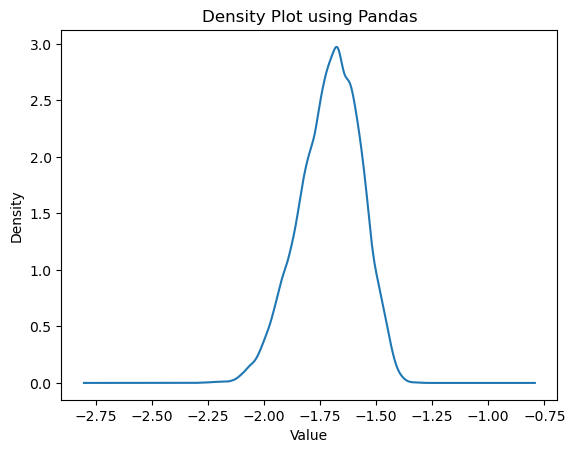

In [4]:
import pandas as pd
theta_series = pd.Series(theta2_samples_flat[:, 0])
theta_series.plot.kde()
plt.title("Density Plot using Pandas")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

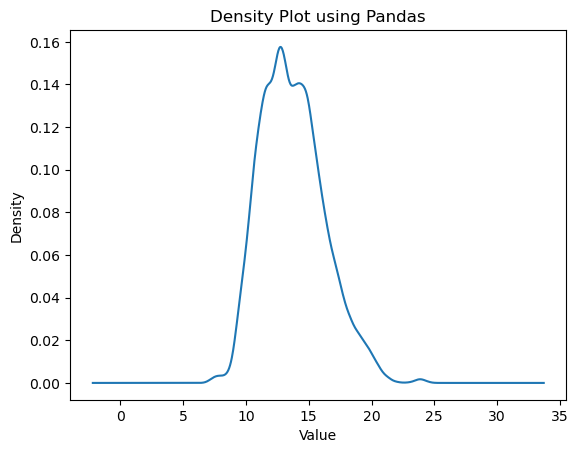

In [5]:
theta_series = pd.Series(theta2_samples_flat[:, 1])
theta_series.plot.kde()
plt.title("Density Plot using Pandas")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

In [6]:
import pyreadr
samples_df = pd.DataFrame(theta2_samples_flat, columns=[f"Dim{i+1}" for i in range(theta2_samples_flat.shape[1])])
output_path = os.path.join(base_dir, "stage2", "theta2_samples_MAF.rds")
pyreadr.write_rds(output_path, samples_df)

/opt/anaconda3/envs/nevi/lib/python3.10/site-packages/pyreadr/_pyreadr_writer.py:154: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['-1.8180445432662964' '-1.6752076148986816' '-1.7049815654754639' ...
 '-1.6076469421386719' '-1.8716306686401367' '-1.7233600616455078']' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  pd_series.loc[pd.notnull(pd_series)] = pd_series.loc[pd.notnull(pd_series)].apply(lambda x: str(x))
/opt/anaconda3/envs/nevi/lib/python3.10/site-packages/pyreadr/_pyreadr_writer.py:154: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['19.441614151000977' '14.712224960327148' '14.786316871643066' ...
 '12.748369216918945' '14.406415939331055' '13.562538146972656']' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  pd_series.loc[